# Risk-Constrained Portfolio Optimization

by Rene Zhang and Max Margenot

Part of the Quantopian Lecture Series:
* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [https://github.com/quantopian/research_public](https://github.com/quantopian/research_public)

---

Risk management is critical for constructing portfolios and building algorithms. Its main function is to improve the quality and consistency of returns by adequately accounting for risk. Any returns obtained by *unexpected* risks, which are always lurking within our portfolio, can usually not be relied upon to produce profits over a long time. By limiting the impact of or eliminating these unexpected risks, the portfolio should ideally only have exposure to the alpha we are pursuing. In this lecture, we will focus on how to use factor model in risk management. 

## Factor Models
We have written many lectures on [Factor Models](https://www.quantopian.com/lectures/the-capital-asset-pricing-model-and-arbitrage-pricing-theory) and the calculation of [Factor Risk Exposure](https://www.quantopian.com/lectures/factor-risk-exposure), as well as [how to analyze alpha factors](https://www.quantopian.com/lectures/factor-analysis). The notation we generally use when introducing a factor model is as follows:

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_k + \epsilon_i$$

where:
$$\begin{eqnarray}
k &=& \text{the number of factors}\\
R_i &=& \text{the return for company $i$}, \\
a_i &=& \text{the intercept},\\
F_j &=& \text{the return for factor $j$, $j \in [1,k]$}, \\
b_{ij} &=& \text{the corresponding exposure to factor $j$, $j \in [1,k]$,} \\
\epsilon_i &=& \text{specific fluctuation of company $i$.}\\
\end{eqnarray}$$



To quantify unexpected risks and have acceptable risk levels in a given portfolio, we need to answer 3 questions:

1. What proportion of the variance of my portfolio comes from common risk factors?
      
2. How do I limit this risk?
   
3. Where does the return/PNL of my portfolio come from, i.e., to what do I attribute the performance?

These risk factors can be:
- Classical fundamental factors, such as those in the [CAPM](https://www.quantopian.com/lectures/the-capital-asset-pricing-model-and-arbitrage-pricing-theory) (market risk) or the [Fama-French 3-Factor Model](https://www.quantopian.com/lectures/fundamental-factor-models) (price-to-book (P/B) ratio, volatility)
- Sector or industry exposure
- Macroeconomic factors, such as inflation or interest rates
- Statistical factors that are based on historical returns and derived from principal component
  analysis

### Universe 

The base universe of assets we use here is the QTradableStocksUS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.research import run_pipeline

In [2]:
# date range for building risk model
start = "2009-01-01"
end = "2011-01-01"

First we pull the returns of every asset in this universe across our desired time period.

In [3]:
def qtus_returns(start_date, end_date):
    pipe = Pipeline(
        columns={'Close': USEquityPricing.close.latest},
        screen = QTradableStocksUS()
    )
    stocks = run_pipeline(pipe, start_date, end_date)  
    unstacked_results = stocks.unstack()
    
    prices = (unstacked_results['Close'].fillna(method='ffill').fillna(method='bfill')
                  .dropna(axis=1,how='any').shift(periods=-1).dropna())  
    qus_returns = prices.pct_change()[1:]
    return qus_returns


R = qtus_returns(start, end)
print "The universe we define includes {} assets.".format(R.shape[1])
print 'The number of timestamps is {} from {} to {}.'.format(R.shape[0], start, end)

The universe we define includes 2041 assets.
The number of timestamps is 503 from 2009-01-01 to 2011-01-01.


In [4]:
assets = R.columns

### Factor Returns and Exposures

We will start with the classic Fama-French factors. The Fama-French factors are the market, company size, and company price-to-book (PB) ratio. We compute each asset's exposures to these factors, computing the factors themselves using pipeline code borrowed from the [Fundamental Factor Models lecture](https://www.quantopian.com/lectures/fundamental-factor-models). 

In [5]:
def make_pipeline():
    """
    Create and return our pipeline.
    
    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation.
    
    In particular, this function can be copy/pasted into the backtester and run by itself.
    """
    # Market Cap
    market_cap = Fundamentals.shares_outstanding.latest/USEquityPricing.close.latest
    # Book to Price ratio
    book_to_price = 1/Fundamentals.pb_ratio.latest
    
    # Build Filters representing the top and bottom 500 stocks by our combined ranking system.
    biggest = market_cap.top(500, mask=QTradableStocksUS())
    smallest = market_cap.bottom(500, mask=QTradableStocksUS())
    
    highpb = book_to_price.top(500, mask=QTradableStocksUS())
    lowpb = book_to_price.bottom(500, mask=QTradableStocksUS())
    
    universe = biggest | smallest | highpb | lowpb
    
    pipe = Pipeline(
        columns = {
            'returns' : Returns(window_length=2),
            'market_cap' : market_cap,
            'book_to_price' : book_to_price,
            'biggest' : biggest,
            'smallest' : smallest,
            'highpb' : highpb,
            'lowpb' : lowpb
        },
        screen=universe
    )
    return pipe

Here we run our pipeline and create the return streams for high-minus-low and small-minus-big.

In [6]:
pipe = make_pipeline()
# This takes a few minutes.
results = run_pipeline(pipe, start, end)
R_biggest = results[results.biggest]['returns'].groupby(level=0).mean()
R_smallest = results[results.smallest]['returns'].groupby(level=0).mean()

R_highpb = results[results.highpb]['returns'].groupby(level=0).mean()
R_lowpb = results[results.lowpb]['returns'].groupby(level=0).mean()

SMB = R_smallest - R_biggest
HML = R_highpb - R_lowpb

df = pd.DataFrame({
         'SMB': SMB, # company size
         'HML': HML  # company PB ratio
    },columns =["SMB","HML"]).shift(periods =-1).dropna()

MKT = get_pricing('SPY', start_date=start, end_date=end, fields='price').pct_change()[1:]
MKT = pd.DataFrame({'MKT':MKT})

F = pd.concat([MKT,df],axis = 1).dropna()

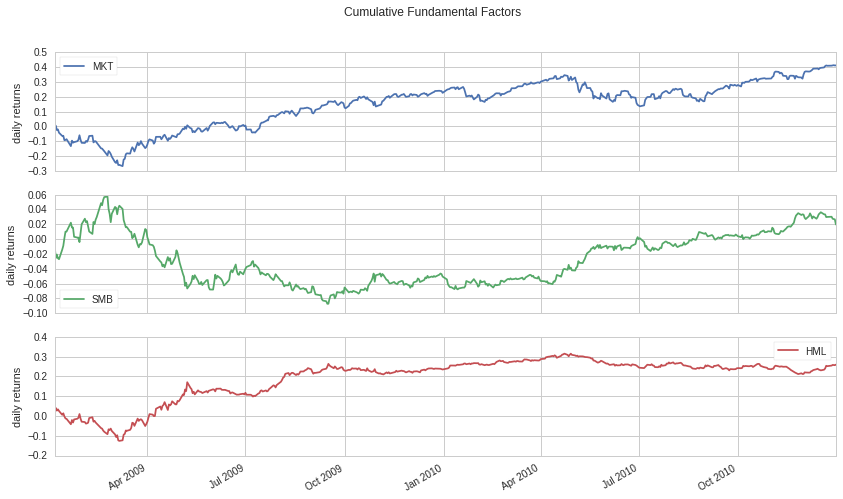

In [7]:
ax = ((F + 1).cumprod() - 1).plot(subplots=True, title='Cumulative Fundamental Factors')
ax[0].set(ylabel = "daily returns")
ax[1].set(ylabel = "daily returns")
ax[2].set(ylabel = "daily returns")
plt.show()

### Calculating the Exposures

Running a multiple linear regression on the fundamental factors for each asset in our universe, we can obtain the corresponding factor exposure for each asset. Here we express:

$$ R_i = \alpha_i + \beta_{i, MKT} R_{i, MKT} + \beta_{i, HML} R_{i, HML} + \beta_{i, SMB} R_{i, SMB} + \epsilon_i$$

for each asset $S_i$. This shows us how much of each individual security's return is made up of these risk factors.

We calculate the risk exposures on an asset-by-asset basis in order to get a more granular view of the risk of our portfolio. This approach requires that we know the holdings of the portfolio itself, on any given day, and is computationally expensive.

In [8]:
# factor exposure
B = pd.DataFrame(index=assets, dtype=np.float32)
epsilon = pd.DataFrame(index=R.index, dtype=np.float32)

In [9]:
x = sm.add_constant(F)

for i in assets:
    y = R.loc[:,i]
    y_inlier = y[np.abs(y - y.mean())<=(3*y.std())]
    x_inlier = x[np.abs(y - y.mean())<=(3*y.std())]
    result = sm.OLS(y_inlier, x_inlier).fit()

    B.loc[i,"MKT_beta"] = result.params[1]
    B.loc[i,"SMB_beta"] = result.params[2]
    B.loc[i,"HML_beta"] = result.params[3]
    epsilon.loc[:,i] = y - (x.iloc[:,0] * result.params[0] +
                            x.iloc[:,1] * result.params[1] + 
                            x.iloc[:,2] * result.params[2] +
                            x.iloc[:,3] * result.params[3])
 

The factor exposures are shown as follows. Each individual asset in our universe will have a different exposure to the three included risk factors.

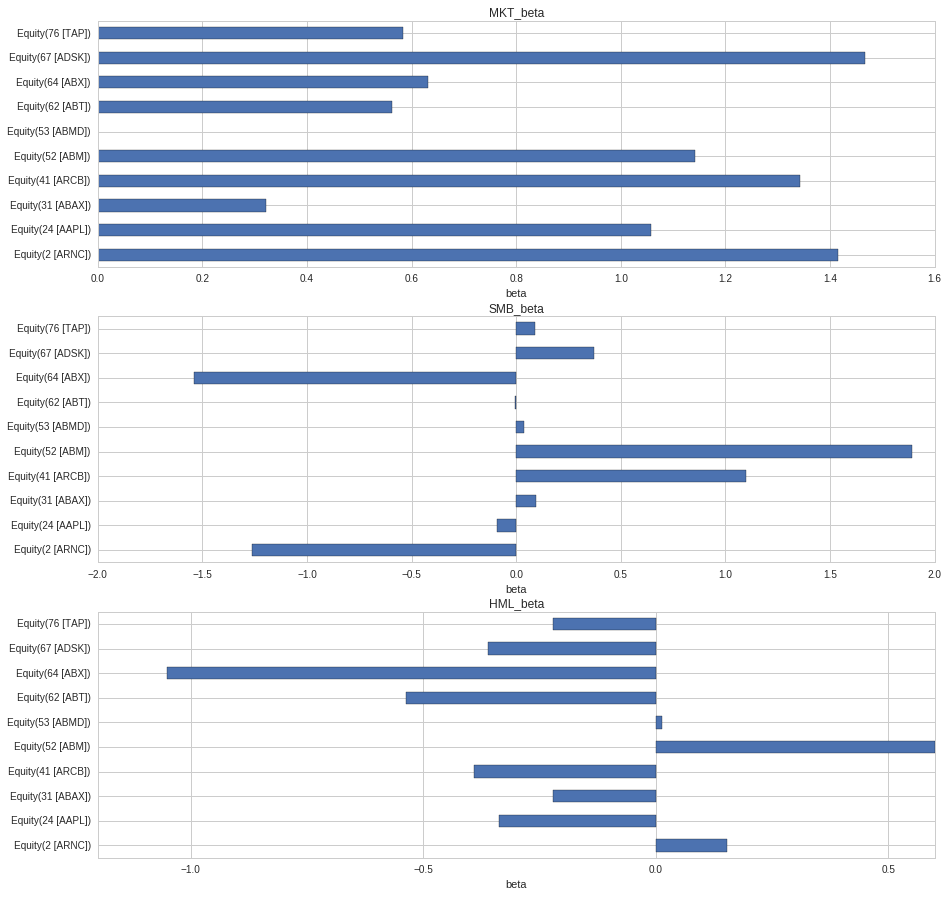

In [10]:
fig,axes = plt.subplots(3, 1)
ax1,ax2,ax3 =axes

B.iloc[0:10,0].plot.barh(ax=ax1, figsize=[15,15], title=B.columns[0])
B.iloc[0:10,1].plot.barh(ax=ax2, figsize=[15,15], title=B.columns[1])
B.iloc[0:10,2].plot.barh(ax=ax3, figsize=[15,15], title=B.columns[2])

ax1.set(xlabel='beta')
ax2.set(xlabel='beta')
ax3.set(xlabel='beta')
plt.show()

In [11]:
B.loc[symbols('AAPL'),:]

MKT_beta    1.058299
SMB_beta   -0.090008
HML_beta   -0.337822
Name: Equity(24 [AAPL]), dtype: float64

### Summary of the Setup:
1. returns of assets in universe: `R`
2. fundamental factors: `F`
3. Exposures of these fundamental factors: `B`

Currently, the `F` DataFrame contains the return streams for MKT, SMB, and HML, by date.

In [12]:
F.head(3)

,MKT,SMB,HML
2009-01-05 00:00:00+00:00,-0.001829,-0.009132,0.014025
2009-01-06 00:00:00+00:00,0.006891,-0.016682,0.026461
2009-01-07 00:00:00+00:00,-0.029319,0.004960,-0.013101


While the `B` DataFrame contains point estimates of the beta exposures **to** MKT, SMB, and HML for every asset in our universe.

In [13]:
B.head(3)

,MKT_beta,SMB_beta,HML_beta
Equity(2 [ARNC]),1.414528,-1.260533,0.153812
Equity(24 [AAPL]),1.058299,-0.090008,-0.337822
Equity(31 [ABAX]),0.322672,0.094498,-0.221841


Now that we have these values, we can start to crack open the variance of any portfolio that contains these assets.

### Splitting Variance into Common Factor Risks

The portfolio variance can be represented as:
  
  $$\sigma^2 = \omega BVB^{\top}\omega^{\top} + \omega D\omega^{\top}$$

where:

$$\begin{eqnarray}
B &=& \text{the matrix of factor exposures of $n$ assets to the factors} \\
    V &=& \text{the covariance matrix of factors} \\
    D &=& \text{the specific variance} \\
    \omega &=& \text{the vector of portfolio weights for $n$ assets}\\
    \omega BVB^{\top}\omega^{\top} &=& \text{common factor variance} \\
    \omega D\omega^{\top} &=& \text{specific variance} \\
\end{eqnarray}$$

#### Computing Common Factor and Specific Variance:

Here we build functions to break out the risk in our portfolio. Suppose that our portfolio consists of all stocks in the Q3000US, equally-weighted. Let's have a look at how much of the variance of the returns in this universe are due to common factor risk.

In [14]:
w = np.ones([1,R.shape[1]])/R.shape[1]

In [15]:
def compute_common_factor_variance(factors, factor_exposures, w):   
    B = np.asarray(factor_exposures)
    F = np.asarray(factors)
    V = np.asarray(factors.cov())
    
    return w.dot(B.dot(V).dot(B.T)).dot(w.T)

common_factor_variance = compute_common_factor_variance(F, B, w)[0][0]
print("Common Factor Variance: {0}".format(common_factor_variance))

Common Factor Variance: 0.000139911491552


In [16]:
def compute_specific_variance(epsilon, w):       
    
    D = np.diag(np.asarray(epsilon.var())) * epsilon.shape[0] / (epsilon.shape[0]-1)

    return w.dot(D).dot(w.T)

specific_variance = compute_specific_variance(epsilon, w)[0][0]
print("Specific Variance: {0}".format(specific_variance))

Specific Variance: 2.33727878586e-07


In order to actually calculate the percentage of our portfolio variance that is made up of common factor risk, we do the following:


$$\frac{\text{common factor variance}}{\text{common factor variance + specific variance}}$$

In [17]:
common_factor_pct = common_factor_variance/(common_factor_variance + specific_variance)*100.0
print("Percentage of Portfolio Variance Due to Common Factor Risk: {0:.2f}%".format(common_factor_pct))

Percentage of Portfolio Variance Due to Common Factor Risk: 99.83%


So we see that if we just take every single security in the Q3000US and equally-weight them, we will end up possessing a portfolio that effectively only contains common risk.

### Risk-Constrained Optimization

Currently we are operating with an equal-weighted portfolio. However, we can reapportion those weights in such a way that we minimize the common factor risk illustrated by our common factor exposures. This is a portfolio optimization problem to find the optimal weights.

We define this problem as:

\begin{array}{ll} \mbox{$\text{minimize/maximum}$}_{w} & \text{objective function}\\
\mbox{subject to} & {\bf 1}^T \omega = 1, \quad f=B^T\omega\\
& \omega \in {\cal W}, \quad f \in {\cal F},
\end{array}

where the variable $w$ is the vector of allocations, the variable $f$ is weighted factor exposures, and  the variable ${\cal F}$ provides our constraints for $f$. We set ${\cal F}$ as a vector to bound the weighted factor exposures of the porfolio. These constraints allow us to reject weightings that do not fit our criteria. For example, we can set the maximum factor exposures that our portfolios can have by changing the value of ${\cal F}$. A value of $[1,1,1]$ would indicate that we want the maximum factor exposure of the portfolio to each factor to be less than $1$, rejecting any portfolios that do not meet that condition.

We define the objective function as whichever business goal we value highest. This can be something such as maximizing the Sharpe ratio or minimizing the volatility. Ultimately, what we want to solve for in this optimization problem is the weights, $\omega$.

Let's quickly generate some random weights to see how the weighted factor exposures of the portfolio change.

In [18]:
w_0 = np.random.rand(R.shape[1])
w_0 = w_0/np.sum(w_0)

The variable $f$ contains the weighted factor exposures of our portfolio, with size equal to the number of factors we have.  As we change $\omega$, our weights, our weighted exposures, $f$, also change.

In [19]:
f = B.T.dot(w_0)
f

MKT_beta    0.888824
SMB_beta    0.274632
HML_beta    0.001556
dtype: float64

A concrete example of this can be found [here](http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb), in the docs for CVXPY.

### Performance Attribution

Let's take a sample algo from the Quantopian forums and attribute its performance using pyfolio. This should give us an understanding of the specific and common risk associated with the algorithm's return stream.

In [20]:
bt_wsj = get_backtest('59232d19c931f1619e6423c9')

100% Time: 0:00:03|###########################################################|


Now we'll run the algorithm using [Quantopian's built-in risk model](https://www.quantopian.com/posts/new-tool-for-quants-the-quantopian-risk-model) and performance attribution tearsheet. We extend beyond the Fama-French Factors, looking into common factor risk due to sectors and due to particular styles of investment that are common in the market.

/usr/local/lib/python2.7/dist-packages/pyfolio/perf_attrib.py:172: UserWarning: Could not determine risk exposures for some of this algorithm's positions. Returns from the missing assets will not be properly accounted for in performance attribution.

The following assets were missing factor loadings: [u'AGII-6276'].. Ignoring for exposure calculation and performance attribution. Ratio of assets missing: 0.001. Average allocation of missing assets:

AGII-6276    1782.992195
dtype: float64.

  warnings.warn(missing_stocks_warning_msg)


Summary Statistics,
Annualized Specific Return,0.082838
Annualized Common Return,0.118462
Annualized Total Return,0.209244
Specific Sharpe Ratio,1.840379


Exposures Summary,Average Risk Factor Exposure,Annualized Return,Cumulative Return
basic_materials,-0.001038,0.004141,0.008299
consumer_cyclical,-0.027212,-0.012042,-0.023940
financial_services,0.019781,0.017751,0.035817
real_estate,-0.005963,0.014573,0.029359
consumer_defensive,0.004187,-0.000505,-0.001009
health_care,0.010517,0.007931,0.015926
utilities,0.010076,0.002534,0.005074
communication_services,-0.003996,-0.000436,-0.000872
energy,0.012374,0.001215,0.002432
industrials,0.002830,0.028271,0.057341


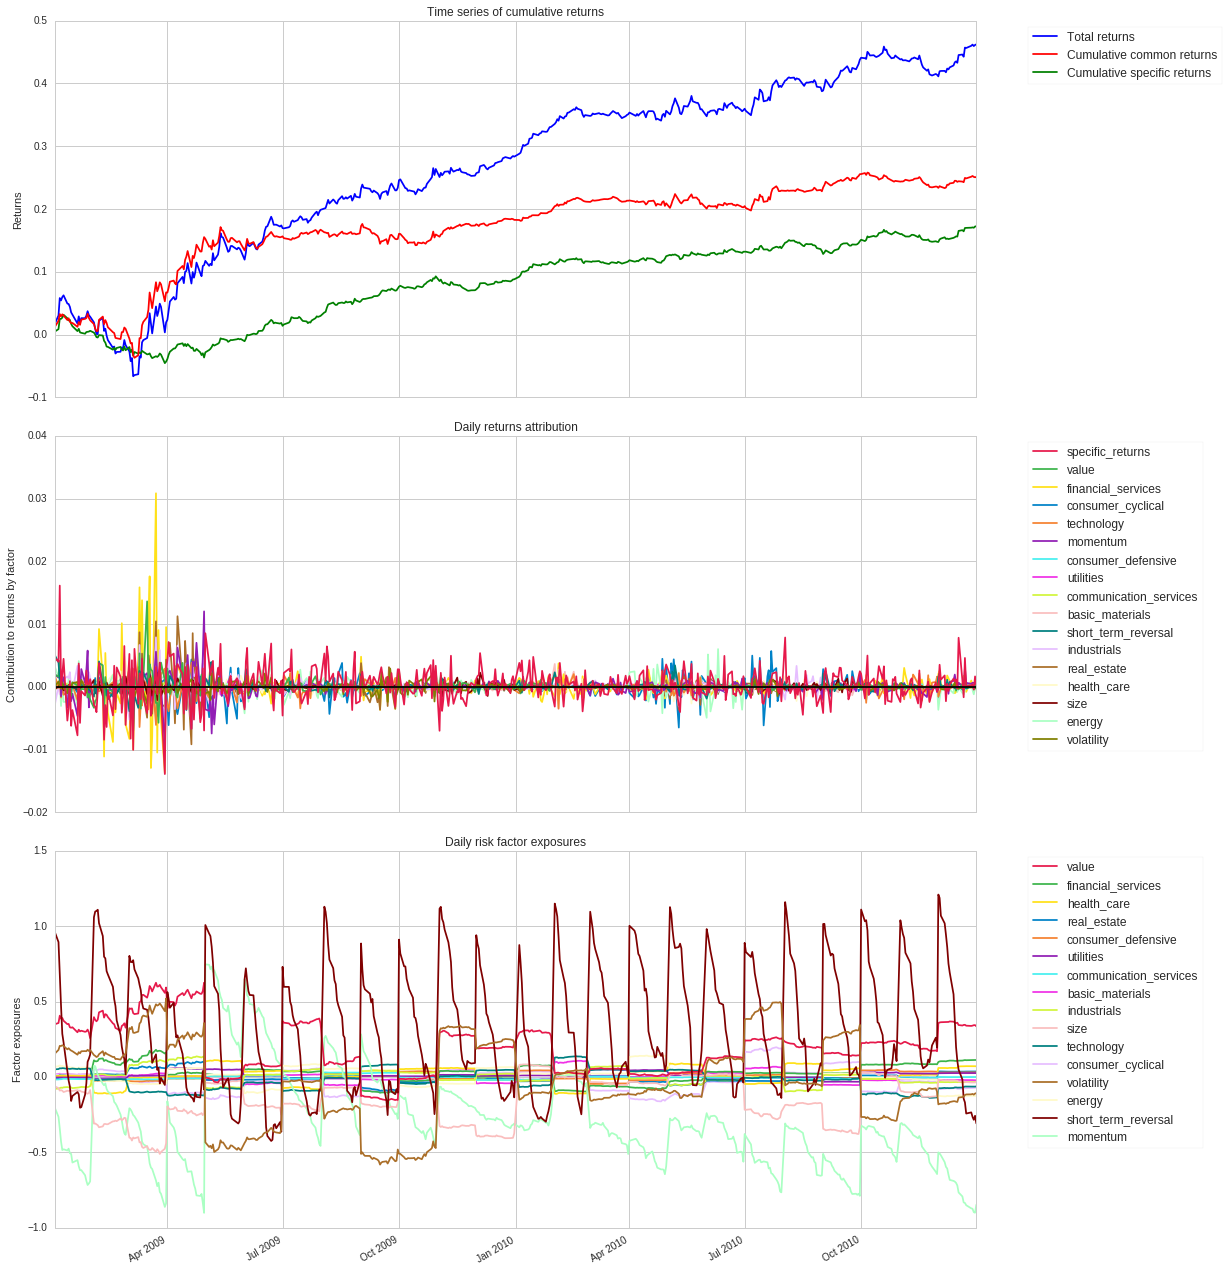

In [21]:
bt_wsj.create_perf_attrib_tear_sheet();

## References
* Qian, E.E., Hua, R.H. and Sorensen, E.H., 2007. *Quantitative equity portfolio management: modern techniques and applications*. CRC Press.
* Narang, R.K., 2013. *Inside the Black Box: A Simple Guide to Quantitative and High Frequency Trading*. John Wiley & Sons.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*